In [ ]:
pip install geopandas shapely r5py datetime 

In [ ]:
from jupyter_dash import JupyterDash
import json
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_leaflet as dl
from dash.dependencies import Output, Input

MAP_ID = "map-id"
COORDINATE_CLICK_ID = "coordinate-click-id"

# Initialize Dash app
app = JupyterDash(__name__, external_scripts=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

# Initialize click counter
click_counter = 0
selected_coords = []

# Clear coord.txt before starting the process
with open("coord.txt", "w") as f:
    f.write("")  # Clear the file content before starting

# Create layout
app.layout = html.Div([
    html.H1("Pulsa en el link de abajo para poder obtener las coordenadas"),
    html.Div([
        # Link that the user clicks to start selecting coordinates
        html.A("Click para empezar", href="#", id="start-link", n_clicks=0),
    ]),
    html.Div(id="map-container", style={"display": "none"}),  # Initially, the map is hidden
    html.Div(id=COORDINATE_CLICK_ID),
    dcc.Store(id="start-clicked", data=False)  # Store component to track if the link was clicked
])

# Callback to display map after the user clicks the link
@app.callback(
    Output("map-container", "style"),
    Output("start-clicked", "data"),
    Input("start-link", "n_clicks")
)
def show_map_on_click(n_clicks):
    if n_clicks > 0:  # If the link has been clicked
        return {"display": "block"}, True  # Show the map
    return {"display": "none"}, False  # Hide the map

# Callback to capture clicks, display coordinates, save to file, and control clicks
@app.callback(Output(COORDINATE_CLICK_ID, 'children'),
              [Input("start-clicked", "data"),
               Input(MAP_ID, 'clickData')])  # Updated to use clickData
def click_coord(start_clicked, click_data):
    global click_counter, selected_coords

    if not start_clicked:
        return "Click the link above to start."
    
    if click_counter == 6:
            return "Ya has seleccionado tus dos localizaciones, no puedes seleccionar más"  # Show message after 2 clicks
    
    if click_data is not None:
        coords = click_data['latlng']  # Extract lat/lng
        
        # Save the coordinates in the selected_coords list
        selected_coords.append(coords)
        
        # Increment the click counter
        click_counter += 1
        
        # After the second click, save both coordinates to the file
        if click_counter == 6:
            with open("coord.txt", "w") as f:
                for coord in selected_coords:
                    f.write(f"Latitude: {coord['lat']}, Longitude: {coord['lng']}\n")
        
        # Return coordinates to display
        return json.dumps(coords)
        

    
    return "-"

# Create the map container, which is displayed after clicking the link
@app.callback(
    Output("map-container", "children"),
    Input("start-clicked", "data")
)
def create_map(start_clicked):
    if start_clicked:
        return dl.Map(id=MAP_ID, style={'width': '1000px', 'height': '500px'}, center=[-1.286389, 36.817223], zoom=12, children=[
            dl.TileLayer()
        ])
    return ""

# Run server in Jupyter Notebook
app.run_server(mode='inline', port=8080, debug=True)



In [1]:
import geopandas as gpd
# import geopandas as gpd
from shapely.geometry import Point
import r5py
import datetime
import pandas as pd
import os

# Function to read coordinates from the coord.txt file
def read_coords_from_file(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    coords = []
    for line in lines:
        # Extract latitude and longitude from the line
        if line.strip():
            parts = line.strip().split(", ")
            lat = float(parts[0].split(":")[1])
            lon = float(parts[1].split(":")[1])
            coords.append((lat, lon))
    return coords

# Read coordinates from coord.txt
coords = read_coords_from_file("coord.txt")

# Set origin (first coordinate) and create the GeoDataFrame for the origin
origin_lat, origin_lon = coords[0]
origin_coords = {"id": [1], "lat": [origin_lat], "lon": [origin_lon]}

origin = gpd.GeoDataFrame(
    origin_coords,
    geometry=[Point(lon, lat) for lon, lat in zip(origin_coords["lon"], origin_coords["lat"])],
    crs="EPSG:4326",
)

# File paths for OSM and GTFS (update paths)
osm_file = "C://Users//Juan//Downloads//nairobi.osm.pbf"
gtfs_files = [
    r"C://Users//Juan//Downloads//gtfs.zip"
]

# Create the transport network
transport_network = r5py.TransportNetwork(osm_file, gtfs_files)

# Departure time (for example, 5:30 AM)
departure_time = datetime.datetime(2020, 2, 1, 17, 10)

# Create an empty DataFrame to store the travel times between points
columns = [f"Dest_{i+1}" for i in range(len(coords)-1)]  # Names for destination columns (starting from 2 to N)
travel_times_df = pd.DataFrame(columns=columns)

# Store the travel times for each departure time in the matrix
travel_times = []

# Loop through all destinations (all coordinates except the first one) and calculate travel time
for idx, (dest_lat, dest_lon) in enumerate(coords[1:], start=2):  # Start at index 2 because index 1 is the origin
    # Set the current destination coordinates
    destination_coords = {"id": [idx], "lat": [dest_lat], "lon": [dest_lon]}

    destination = gpd.GeoDataFrame(
        destination_coords,
        geometry=[Point(lon, lat) for lon, lat in zip(destination_coords["lon"], destination_coords["lat"])],
        crs="EPSG:4326",
    )

    # Compute travel time for the current origin and destination
    travel_time_matrix = r5py.TravelTimeMatrixComputer(
        transport_network,
        origins=origin,
        destinations=destination,
        departure=departure_time,
        transport_modes=[r5py.TransportMode.TRANSIT, r5py.TransportMode.WALK],
    ).compute_travel_times()

    # Store the travel time for this destination (add to the row)
    travel_times.append(travel_time_matrix.iloc[0]["travel_time"])

# Add the travel times as a row in the DataFrameformat='%Y-%m-%d %H:%M'
travel_times_df.loc[departure_time.strftime("%Y-%m-%d %H:%M")] = travel_times  # Use the departure time as the index

# File path for the CSV
csv_file_path = "travel_timess.csv"

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # If it exists, load the existing CSV file
    existing_df = pd.read_csv(csv_file_path, index_col="Departure Time")
    # Append the new data to the existing DataFrame using pd.concat
    updated_df = pd.concat([existing_df, travel_times_df])
else:
    # If the file does not exist, the updated DataFrame will be the travel_times_df
    updated_df = travel_times_df

# Save the updated DataFrame to the CSV file (without overwriting previous data)
updated_df.to_csv(csv_file_path, index_label="Departure Time")

# Print the updated travel times DataFrame
print(updated_df)

                  Dest_1  Dest_2  Dest_3  Dest_4  Dest_5
2020-02-12 08:10    45.0    54.0    50.0    50.0    49.0
2020-02-12 11:10    51.0    61.0    57.0    60.0    58.0
2020-02-12 21:10    71.0     NaN     NaN     NaN     NaN
2020-02-16 21:10    71.0     NaN     NaN     NaN     NaN
2020-02-16 09:10    51.0    60.0    57.0    60.0    60.0
2020-02-16 10:10    52.0    60.0    58.0    62.0    60.0
2020-02-16 08:10    45.0    77.0    70.0    51.0    67.0
2020-02-16 22:10   117.0     NaN     NaN     NaN     NaN
2020-02-12 22:10   117.0     NaN     NaN     NaN     NaN
2020-02-16 18:10    45.0    76.0    71.0    51.0    64.0
2020-02-16 19:10    45.0    77.0    70.0    51.0    65.0
2020-02-16 20:10    45.0    77.0    70.0    52.0    68.0
2020-02-16 12:10    51.0    86.0    81.0    59.0    75.0
2020-02-16 14:10    52.0    87.0    80.0    58.0    74.0
2020-02-16 15:10    46.0    77.0    69.0    51.0    66.0
2020-02-16 16:10    45.0    77.0    69.0    52.0    65.0
2020-02-16 16:45    45.0    77.

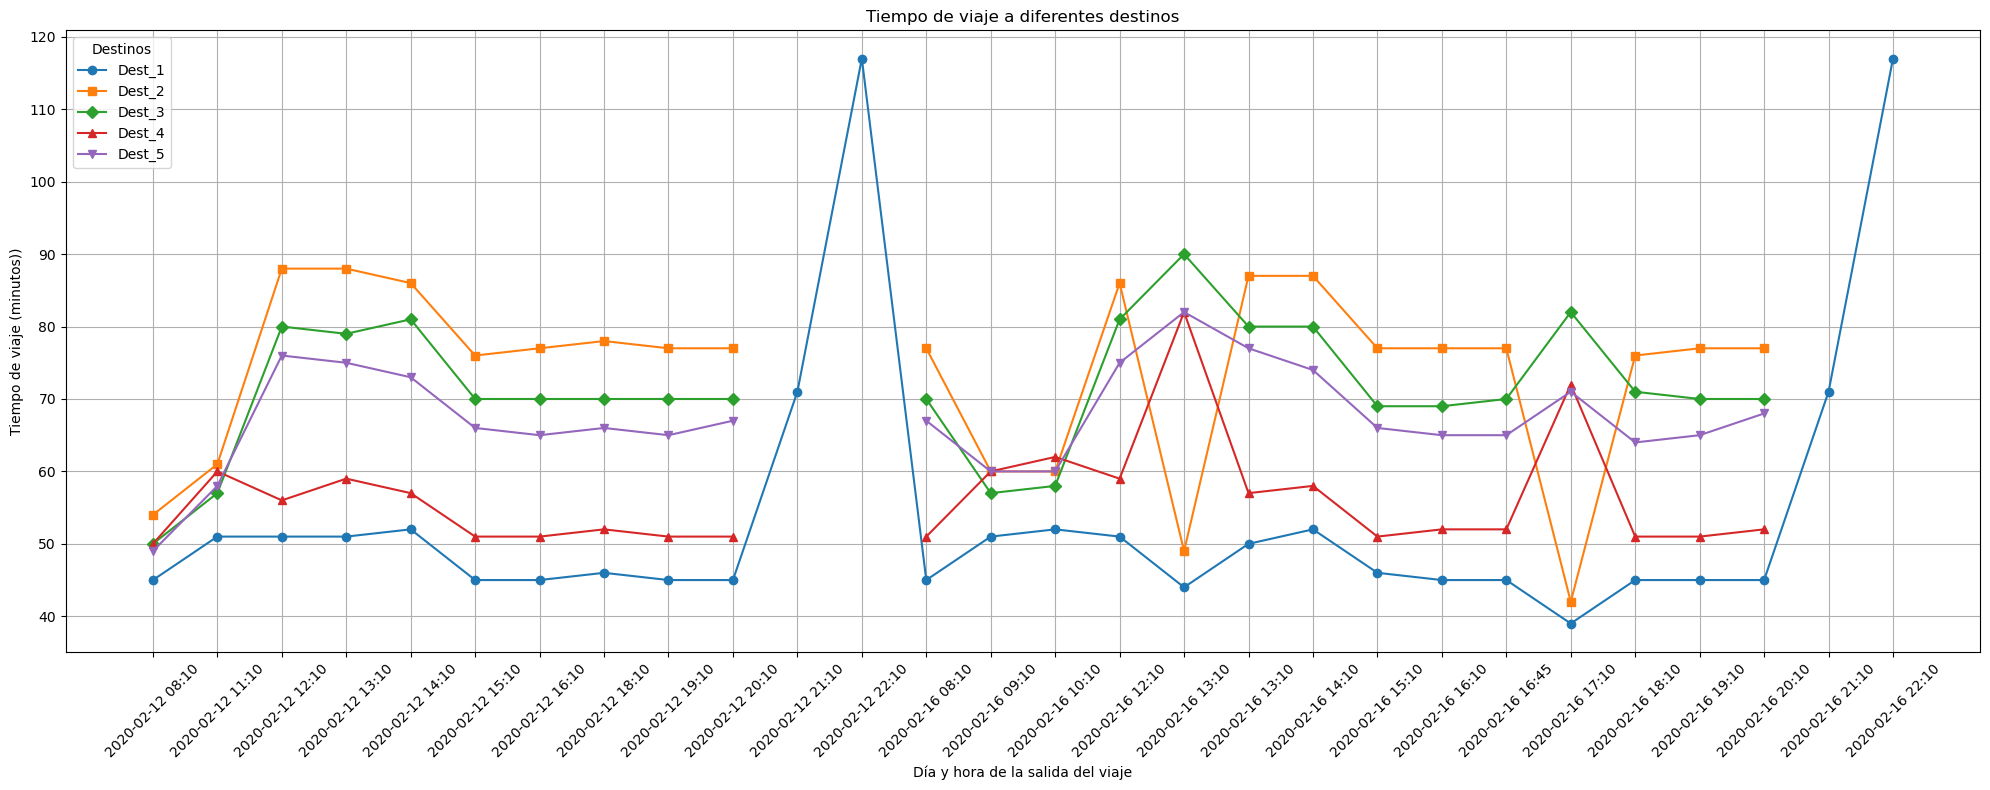

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
travel_times_df = pd.read_csv("travel_timess.csv", index_col="Departure Time")

# Convert 'Departure Time' to datetime (with full date and time)
travel_times_df.index = pd.to_datetime(travel_times_df.index)

# Sort by the datetime index (departure time)
travel_times_df.sort_index(inplace=True)

# Convert the datetime index to strings (only dates, without time)
x_labels = travel_times_df.index.strftime('%Y-%m-%d %H:%M')

# Plotting
plt.figure(figsize=(20, 8))  # Slightly wider figure to accommodate longer labels

# Use numerical x-values for plotting
x_values = range(len(x_labels))

# Define a list of markers and colors for different destinations
markers = ['o', 's', 'D', '^', 'v']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # New color palette

# Plot each destination with a unique marker and color
for i, column in enumerate(travel_times_df.columns):
    plt.plot(x_values, travel_times_df[column], marker=markers[i], color=colors[i], label=column)

# Set x-ticks and labels
plt.xticks(x_values, x_labels, rotation=45)

plt.xlabel('Día y hora de la salida del viaje')
plt.ylabel('Tiempo de viaje (minutos))')
plt.title('Tiempo de viaje a diferentes destinos')
plt.legend(title='Destinos')
plt.grid(True)
plt.tight_layout()
plt.show()

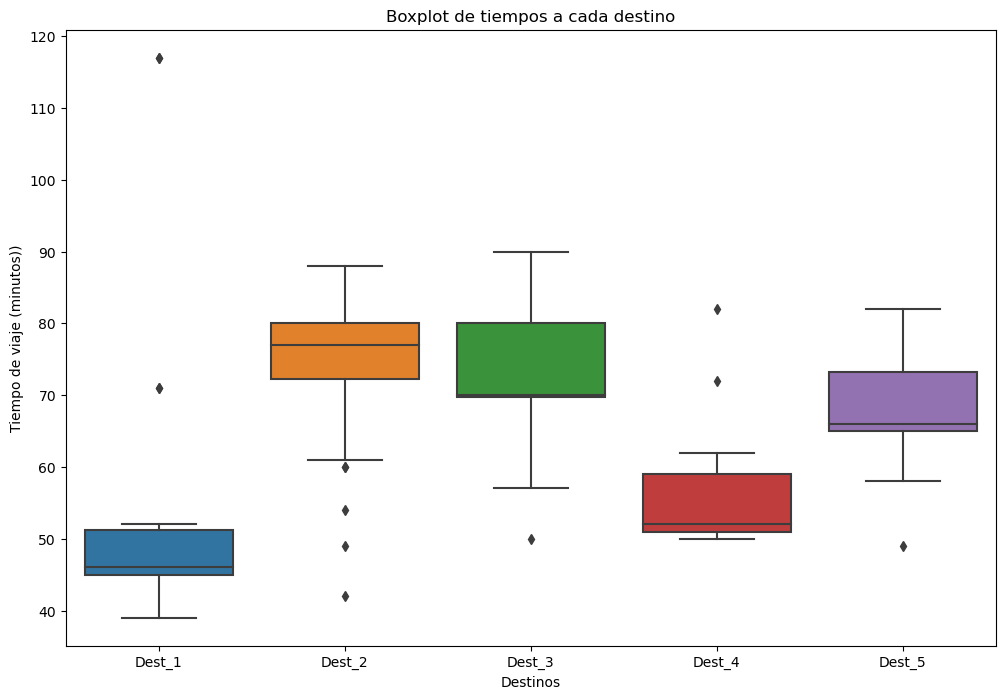

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plt.figure(figsize=(12, 8))
sns.boxplot(data=travel_times_df)
plt.title('Boxplot de tiempos a cada destino')
plt.xlabel('Destinos')
plt.ylabel('Tiempo de viaje (minutos))')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML

# Load the CSV file
travel_times_df = pd.read_csv("travel_timess.csv", index_col="Departure Time")

# Convert 'Departure Time' to datetime (with full date and time)
travel_times_df.index = pd.to_datetime(travel_times_df.index)

# Sort by the datetime index (departure time)
travel_times_df.sort_index(inplace=True)

# Convert the datetime index to strings (only dates, without time)
x_labels = travel_times_df.index.strftime('%Y-%m-%d %H:%M')

# Use numerical x-values for plotting
x_values = range(len(x_labels))

# Define a list of markers and colors for different destinations
markers = ['o', 's', 'D', '^', 'v']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Increase figure size (bigger height)
fig, ax = plt.subplots(figsize=(16, 12))  # Wider and taller

# Get max value for scaling y-axis
max_val = travel_times_df.max().max()
min_val = travel_times_df.min().min()

# Define the animate function to update the plot
def animate(i):
    ax.clear()  # Clear the previous frame
    
    # Plot each destination
    for idx, column in enumerate(travel_times_df.columns):
        ax.plot(x_values[:i], travel_times_df[column].iloc[:i], 
                marker=markers[idx % len(markers)], color=colors[idx % len(colors)], 
                label=column)

    ax.set_xticks(x_values)  # Set x-ticks
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)  # Adjust font size
    ax.set_title('Travel Times to Different Destinations', fontsize=18)
    ax.set_xlabel('Departure Date and Time', fontsize=16)
    ax.set_ylabel('Travel Time (minutes)', fontsize=16)
    
    # Extend y-axis more for better visibility
    ax.set_ylim([min_val-15, max_val +10])  
    
    ax.margins(x=0.05)  # Add space on the x-axis
    ax.legend(title="Destination", fontsize=12)  # Add legend

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(x_values), interval=200)

# Save the animation as a GIF
ani.save('animation.gif', writer='pillow', fps=1.5)

# Close the figure to prevent extra display in Jupyter Notebook
plt.close(fig)

# Display the animation in Jupyter Notebook
HTML(ani.to_jshtml())


In [ ]:
ani.save('animation.gif', writer='pillow', fps=1.5)

In [ ]:
import folium
import pandas as pd

# Read the coordinates file and extract numeric values
coords = []
with open("coord.txt", "r") as file:
    for line in file:
        parts = line.strip().split(",")  # Split by comma
        lat = float(parts[0].split(":")[1].strip())  # Extract the numeric part
        lon = float(parts[1].split(":")[1].strip())
        coords.append((lat, lon))

# Convert to DataFrame
coords_df = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

# Define the map center (average of lat/lon)
map_center = [coords_df["Latitude"].mean(), coords_df["Longitude"].mean()]

# Create a folium map
m = folium.Map(location=map_center, zoom_start=12)

# Add numbered markers for each coordinate
for i, row in enumerate(coords_df.itertuples(), start=1):  # Numbered from 1
    folium.Marker(
        location=[row.Latitude, row.Longitude],
        popup=f"Point {i}: {row.Latitude}, {row.Longitude}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: blue;"><b>{i}</b></div>')
    ).add_to(m)

# Display map in Jupyter Notebook
m
